<a href="https://colab.research.google.com/github/cakirfatih/Test/blob/master/1D_Conv_Mel_fc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  1 23:05:50 2020

@author: kosed
"""
import os
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from os.path import dirname, join as pjoin
import warnings
import torch
import PIL
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sn
from sklearn.metrics import multilabel_confusion_matrix
from torch.autograd import Variable
warnings.filterwarnings('ignore')
import cv2
from sklearn.metrics import classification_report

In [17]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def report_performance(predictions, labels):
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    
        
    if type(predictions).__module__ == torch.__name__ :
        predictions = predictions.tolist()
    if type(labels).__module__ == torch.__name__ :
        labels = labels.tolist()
    
    if type(predictions).__module__ == np.__name__ :
        predictions = list(predictions)
    if type(labels).__module__ == np.__name__ :
        labels = list(labels)
    

    
    size = len(genres);
    i = 0;
    
    while i < 10:
        if i in predictions:        
            for j, x in enumerate(predictions):
                if x == i:
                   predictions[j] = genres[i + size - 10]
        if i in labels:
            for j, x in enumerate(labels):
                if x == i: 
                    labels[j] = genres[i + size - 10]
        else: 
            del genres[i + size - 10]
            size -= 1
        i+=1; 
          

    data = {'y_Actual':    labels,
            'y_Predicted': predictions
            }
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
   
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()
    print(classification_report(labels, predictions))
    
    cnf = multilabel_confusion_matrix(labels, predictions)

    for i in range(0, len(genres)):
        if (cnf[i][0][1]+cnf[i][1][1]) != 0:
            print("Accuracy for", genres[i], "is:", cnf[i][1][1]/(cnf[i][0][1]+cnf[i][1][1]), "\n")

In [0]:
# %%  EXTRACT SOUND WAVES FROM SONGS

def extract_data():
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    data = []
    for g in genres:
        for filename in os.listdir(f'drive/My Drive/machine learning/rescaled400_daha_net/{g}'):
            songname = f'drive/My Drive/machine learning/rescaled400_daha_net/{g}/{filename}'
            temp = plt.imread(songname)[:,:,:3]
            data.append(temp)
    return data

def shuffle(data, classes):
    dataset = np.r_['1', data, classes]
    np.random.shuffle(dataset)
    n, m = np.shape(dataset)
    train_size = 700
    validation_size = 100
    test_size = 200
    train_data = dataset[:train_size].astype(dtype='float32')
    x_train_data = train_data[:,0:m-1]
    y_train_data = train_data[:,m-1]
    x_train_data = np.reshape(x_train_data, (train_size,-1,3))
    y_train_data = np.reshape(y_train_data, (train_size))
    train_data = []
    for i in range(train_size):
        train_data.append([x_train_data[i], y_train_data[i]])

    validation_data = dataset[train_size:train_size+validation_size].astype(dtype='float32')
    x_validation_data = validation_data[:,0:m-1]
    y_validation_data = validation_data[:,m-1]

    x_validation_data = np.reshape(x_validation_data, (validation_size,-1,3))
    y_validation_data = np.reshape(y_validation_data, (validation_size))
    
    validation_data = []
    for i in range(validation_size):
        validation_data.append([x_validation_data[i], y_validation_data[i]])
    
    
    test_data = dataset[800:].astype(dtype='float32')
    x_test_data = test_data[:,0:m-1]
    y_test_data = test_data[:,m-1]
    x_test_data = np.reshape(x_test_data, (test_size,-1,3))
    y_test_data = np.reshape(y_test_data, (test_size))
    test_data = []
    for i in range(test_size):
        test_data.append([x_test_data[i], y_test_data[i]])
    
    return train_data, validation_data, test_data

def construct_labels():
    labels = []
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    numeration = [0,1,2,3,4,5,6,7,8,9]
    for g in numeration:
        for i in range(100):
            labels.append(g)
    return np.reshape(labels,(1000,1))





In [0]:
# %% Main
data = extract_data()
data = np.reshape(data, (np.shape(data)[0],-1,3))
data = np.reshape(data, (np.shape(data)[0],-1))
label = construct_labels()
train_data, validation_data, test_data = shuffle(data, label)

In [0]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [0]:
# %% model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):

    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(3, 8, 4,stride = 2)
        torch.nn.init.xavier_normal(self.conv1.weight)
        self.conv2 = nn.Conv1d(8, 16, 32,stride = 2)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.conv3 = nn.Conv1d(16, 64, 16,stride = 2)
        torch.nn.init.xavier_normal(self.conv3.weight)
        self.ap = nn.AvgPool1d(4)
        self.mp = nn.MaxPool1d(4)
        self.fc = nn.Linear(249300, 100)
        self.fc4 = nn.Linear(159232,100)
        #self.fc3 = nn.Linear(159616,100)
        self.fc3 = nn.Linear(19840,100)        
        self.fc2 = nn.Linear(100, 10)
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.ap(self.conv1(x)))
        x = F.relu(self.ap(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))
        x = x.view(in_size, -1)
        if (len(x[1]) == 249300):
          x = F.relu(self.fc(x))
        elif (len(x[1]) == 159232):
          x = F.relu(self.fc4(x))
        else:
          x = F.relu(self.fc3(x))
        x = self.fc2(x)
        
        return F.log_softmax(x)


def train(epoch, batchsize):
    
    model.train()
    total_loss = 0
    train_acc = 0
    c = 0;
    for batch_idx, data in enumerate(train_loader):
        c += 1
        label = data[1]
        label = label.to(dtype=torch.int64)
        data = data[0]
        data = np.reshape(data,(batch_size, 3, -1))
        data, target = Variable(data), Variable(label)
        optimizer.zero_grad()
        
        output = model(data.to(device))
        
        loss = F.nll_loss(output.to(device), target.to(device))
        total_loss += loss.detach().item()
        loss.backward()
        optimizer.step()

        train_acc += get_accuracy(output.to('cpu'), target, batch_size)

        if( batch_idx % 2 == 0 ):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain Accuracy: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item(), (train_acc/c)))
    return total_loss / batch_idx, train_acc/c
def validate():
    correct = 0
    total = 0
    

    for data in (validation_loader):
      
        label = data[1]
        label = label.to(dtype=torch.int64)

        data = data[0]
        data = np.reshape(data, (100, 3, -1))
        data, target = Variable(data), Variable(label)

        output = model(data.to(device))

        _, predicted = torch.max(output.data, 1)

        total += target.size(0)

        correct += (predicted.to('cpu') == target).sum()

    accuracy = 100 * correct / total
    print('Validation Accuracy: %.2f \n' 
            %(accuracy))
    return accuracy

def test(batchsize):
    model.eval()
    total = 0
    test_loss = 0
    correct = 0
    correct_2 = 0
    correct_3 = 0
    total_pred = []
    total_target = []
    total_loss = 0
    for data in test_loader:
        
        label = data[1]
        label = label.to(dtype=torch.int64)
        data = data[0]
        data = np.reshape(data,(batchsize, 3, -1))
        data, target = Variable(data), Variable(label)
        
        output = model(data.to(device))
        
        test_loss = F.nll_loss(output.to('cpu'), target.to('cpu'))
        total_loss += test_loss

        _, predicted = torch.topk(output.data, 3)
        pred = output.data.max(1, keepdim=True)[1]
        target = target.to(device)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        correct_2 += (predicted[:,0] == target).sum() + (predicted[:,1] == target).sum()  
        correct_3 += (predicted[:,0] == target).sum() + (predicted[:,1] == target).sum()  + (predicted[:,2] == target).sum() 
        total += target.size(0)

        ###########################################################
        temp = pred.data.cpu().numpy()
        temp2 = target.data.cpu().numpy()
        temp = np.reshape(temp, (-1))
        temp2 = np.reshape(temp2, (-1))
        total_pred = np.concatenate((total_pred, temp), axis=0)
        total_target= np.concatenate((total_target, temp2), axis=0)
        #############################################################
    

    accuracy_top_2 = 100 * correct_2 / total
    accuracy_top_3 = 100 * correct_3 / total


    print("Top 2 prediction accuracy: %.1f%%" %(accuracy_top_2.item()))
    print("Top 3 prediction accuracy: %.1f%%" %(accuracy_top_3.item()))
    
    test_loss /=  len(test_loader.dataset)
    total_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 
                                                                                     100. * correct / len(test_loader.dataset)))
    return total_pred, total_target, test_loss, ( 100.00 * correct / len(test_loader.dataset))

#

In [0]:
# %% 
# Training settings
batch_size = 70
validation_batch_size = 100
test_batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = batch_size,
                                           shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_data, batch_size = validation_batch_size,shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size = test_batch_size,
                                          shuffle=False)



In [0]:
# %% Model 
model = Net()
model = model.to(device)

In [25]:
# %%
#criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch=100
test_loss_hist = np.arange(epoch).astype(dtype='float')
train_loss_hist = np.arange(epoch).astype(dtype='float')
validation_accuracy_hist = np.arange(epoch).astype(dtype='float')
train_accuracy_hist = np.arange(epoch).astype(dtype='float')
count = 0;
for i in range(epoch):
    train_loss_hist[i], train_accuracy_hist[i] = train(i, batch_size)
    validation_accuracy_hist[i] = validate()
    if (train_accuracy_hist[i] > 90):
      break
    count += 1

Train Epoch: 0 [0/700 (0%)]	Loss: 2.307512	Train Accuracy: 11.428572
Train Epoch: 0 [140/700 (20%)]	Loss: 2.295065	Train Accuracy: 11.904762
Train Epoch: 0 [280/700 (40%)]	Loss: 2.318824	Train Accuracy: 10.857143
Train Epoch: 0 [420/700 (60%)]	Loss: 2.319997	Train Accuracy: 10.816326
Train Epoch: 0 [560/700 (80%)]	Loss: 2.301627	Train Accuracy: 10.793651
Validation Accuracy: 8.00 

Train Epoch: 1 [0/700 (0%)]	Loss: 2.287952	Train Accuracy: 11.428572
Train Epoch: 1 [140/700 (20%)]	Loss: 2.283454	Train Accuracy: 11.904762
Train Epoch: 1 [280/700 (40%)]	Loss: 2.311116	Train Accuracy: 12.571429
Train Epoch: 1 [420/700 (60%)]	Loss: 2.300872	Train Accuracy: 11.428572
Train Epoch: 1 [560/700 (80%)]	Loss: 2.282169	Train Accuracy: 12.063492
Validation Accuracy: 17.00 

Train Epoch: 2 [0/700 (0%)]	Loss: 2.269446	Train Accuracy: 18.571428
Train Epoch: 2 [140/700 (20%)]	Loss: 2.251622	Train Accuracy: 23.333334
Train Epoch: 2 [280/700 (40%)]	Loss: 2.267414	Train Accuracy: 19.428572
Train Epoch: 2 [

Top 2 prediction accuracy: 81.0%
Top 3 prediction accuracy: 89.0%

Test set: Average loss: 0.0129, Accuracy: 132/200 (66%)



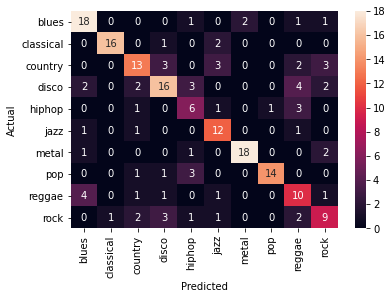

              precision    recall  f1-score   support

       blues       0.69      0.78      0.73        23
   classical       0.94      0.84      0.89        19
     country       0.62      0.54      0.58        24
       disco       0.64      0.55      0.59        29
      hiphop       0.40      0.50      0.44        12
        jazz       0.60      0.80      0.69        15
       metal       0.90      0.82      0.86        22
         pop       0.93      0.74      0.82        19
      reggae       0.43      0.56      0.49        18
        rock       0.50      0.47      0.49        19

    accuracy                           0.66       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.68      0.66      0.66       200

Accuracy for blues is: 0.6923076923076923 

Accuracy for classical is: 0.9411764705882353 

Accuracy for country is: 0.6190476190476191 

Accuracy for disco is: 0.64 

Accuracy for hiphop is: 0.4 

Accuracy for jazz is: 0.6 

Accuracy for me

In [33]:
test_accuracy_hist = np.arange(epoch).astype(dtype='float')
pred, target, test_loss_hist, test_accuracy_hist = test(test_batch_size)
report_performance(pred, target)

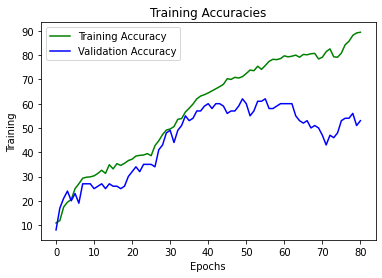

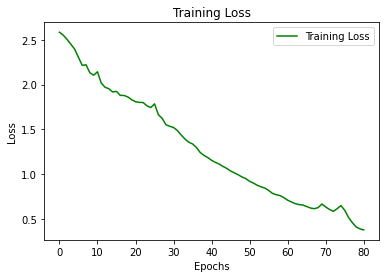

The End


In [27]:
#%%
plt.plot( train_accuracy_hist[:count], 'g', label='Training Accuracy')
plt.plot(validation_accuracy_hist[:count], 'b', label='Validation Accuracy')
plt.title('Training Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.legend()
plt.show()  



plt.plot(train_loss_hist[:count], 'g', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()  


print("The End")